In [77]:
### Necessary libraries ###
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
import sklearn
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

In [2]:
### Load data ###
import pandas as pd
data = pd.read_csv('diabetic_data.csv')
print(data.shape)

(101766, 50)


In [3]:
### Feature types ###
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [4]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
### Number of classes in target values (readmitted) ###
data.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

In [6]:
'''Number of classes in Target values shows that we can treat them a ballanced data'''

'Number of classes in Target values shows that we can treat them a ballanced data'

In [7]:
### Investigation of the discharge_disposition_id ###
data.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

In [8]:
'''Investigation of the IDs mapping shows that discharge_disposition_id 
 with ids "11,13,14,19,20,21" related to patiants who died or will die and
 there is no more chance for being readmitted to the hospital. Therefore, 
 datapoints with these IDs removal is essential'''

'Investigation of the IDs mapping shows that discharge_disposition_id \n with ids "11,13,14,19,20,21" related to patiants who died or will die and\n there is no more chance for being readmitted to the hospital. Therefore, \n datapoints with these IDs removal is essential'

In [9]:
### Removing data points with discharge_disposition_id equal to [11,13,14,19,20,21] ###
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [10]:
### Replacing '?' with numpy nan values ###
data = data.replace('?',np.nan)

In [11]:
### List for numerical features ###
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

In [12]:
### Nulls in numericall features ###
data[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

In [13]:
'''There is no 'null' in the numerical features'''

"There is no 'null' in the numerical features"

In [14]:
### Sclaing numerical features to speed up the computations ###
from sklearn.preprocessing import StandardScaler
data[cols_num] = StandardScaler().fit_transform(data[cols_num])
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,-1.138438,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,-0.464673,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,-0.801555,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,-0.801555,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,-1.138438,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [15]:
### List for categorical features ###
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

In [16]:
### Nulls in categorical features ###
data[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

In [17]:
'''race and payer_code have null values'''

'race and payer_code have null values'

In [18]:
### Handling na in race, payer_code, and medical_specialty ### 
data['race'] = data['race'].fillna('Null')
data['payer_code'] = data['payer_code'].fillna('Null')
data['medical_specialty'] = data['medical_specialty'].fillna('Null')

In [19]:
### Investigating distinct labels in medical_specialty ###
print('Number medical specialty:', data.medical_specialty.nunique())
data.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
Null                                 48616
InternalMedicine                     14237
Emergency/Trauma                      7419
Family/GeneralPractice                7252
Cardiology                            5279
Surgery-General                       3059
Nephrology                            1539
Orthopedics                           1392
Orthopedics-Reconstructive            1230
Radiologist                           1121
Pulmonology                            854
Psychiatry                             853
Urology                                682
ObstetricsandGynecology                669
Surgery-Cardiovascular/Thoracic        642
Gastroenterology                       538
Surgery-Vascular                       525
Surgery-Neuro                          462
PhysicalMedicineandRehabilitation      391
Oncology                               319
Pediatrics                             253
Neurology                              201
Hematology/Oncology                 

In [21]:
''' Using all 73 lables for the modeling can increse the dimensionality of the input features since we will use one hot encoder for categorical features. It results in increasing the complexity of models. There are 73 unique labels in 
medical_specialty. So, to avoid the mentioned issue and use this feature more efficintly, top 10 labels with high frequeancies are used directly in the modeling. The remaining lables are grouped and used as one single lable in the computation.'''

' Using all 73 lables for the modeling can increse the dimensionality of the input features since we will use one hot encoder for categorical features. It results in increasing the complexity of models. There are 73 unique labels in \nmedical_specialty. So, to avoid the mentioned issue and use this feature more efficintly, top 10 labels with high frequeancies are used directly in the modeling. The remaining lables are grouped and used as one single lable in the computation.'

In [22]:
### Top 10 labels with higher frequency ###
top_10 = ['Unknown','InternalMedicine','Emergency/Trauma','Family/GeneralPractice','Cardiology','Surgery-General','Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
data['med_spec'] = data['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
data.loc[~data.med_spec.isin(top_10),'med_spec'] = 'Other'

In [23]:
data.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                         56815
Radiologist                    1121
Surgery-General                3059
dtype: int64

In [25]:
'''Now, after instead of having 73 labels, there are 11 labels in the new created med_spec feature. '''

'Now, after instead of having 73 labels, there are 11 labels in the new created med_spec feature. '

In [26]:
### Changing data type of categorical features with numerical labels to string ###
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
data[cols_cat_num] = data[cols_cat_num].astype('str')

In [27]:
### Creating dummies from categorical features to use in the predictive models ###
data_cat = pd.get_dummies(data[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [28]:
data_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Null,race_Other,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,admission_source_id_9,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
### Joining Categorical features to the main dataset ###
data = pd.concat([data,data_cat], axis = 1)

In [30]:
### Creating a list of all categorical features ###
cols_all_cat = list(data_cat.columns)

In [31]:
### Handling age and weight features which are special features in this dataset ### 
data[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


In [32]:
data.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [33]:
### Creating new ids for 'age' feature with name 'age_group' ###
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
data['age_group'] = data.age.replace(age_id)

In [34]:
print('No patient weight reported:', data.weight.isnull().sum())
print('Patient weight reported:', data.weight.notnull().sum())

No patient weight reported: 96218
Patient weight reported: 3125


In [ ]:
'''Patient weight is mostly missing'''

In [36]:
### Using 'weight' feature to create a new feature named 'has_weight' ###
data['has_weight'] = data.weight.notnull().astype('int')

In [37]:
### Create a list of  special features ###
cols_special = ['age_group','has_weight']

In [40]:
### Feature info after cleaning the data ###
print('Total number of features:', len(cols_num + cols_all_cat + cols_special))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_special))

Total number of features: 142
Numerical Features: 8
Categorical Features: 132
Extra features: 2


In [45]:
### Making sure there is no more null in the cleaned data ###
data[cols_num + cols_all_cat + cols_special].isnull().sum().sort_values(ascending = False).head(10)

has_weight              0
pioglitazone_No         0
acarbose_No             0
rosiglitazone_Up        0
rosiglitazone_Steady    0
rosiglitazone_No        0
pioglitazone_Up         0
pioglitazone_Steady     0
tolbutamide_Steady      0
acarbose_Up             0
dtype: int64

In [44]:
### Encoding multiclass target feature 'readmitted' ###
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data['readmitted'] = labelencoder.fit_transform(data['readmitted'])

In [47]:
### Finalizing dataset to use for modeling by adding label encoded target feature 'readmitted' ###
col2use = cols_num + cols_all_cat + cols_special
data_ready = data[col2use + ['readmitted']]
data_ready.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,age_group,has_weight,readmitted
0,-1.138438,-0.097243,-0.783565,-1.850439,-0.291863,-0.211622,-0.500575,-3.298145,0,1,...,0,0,0,0,1,0,0,0,0,2
1,-0.464673,0.820659,-0.783565,0.249657,-0.291863,-0.211622,-0.500575,0.823436,0,1,...,0,0,0,0,1,0,0,10,0,1
2,-0.801555,-1.627080,2.152815,-0.368019,1.288995,-0.211622,0.292810,-0.722157,0,0,...,0,0,0,0,1,0,0,20,0,2
3,-0.801555,0.055741,-0.196289,0.002587,-0.291863,-0.211622,-0.500575,-0.206960,0,1,...,0,0,0,0,1,0,0,30,0,2
4,-1.138438,0.412703,-0.783565,-0.985694,-0.291863,-0.211622,-0.500575,-1.237355,0,1,...,0,0,0,0,1,0,0,40,0,2


In [48]:
data_ready.shape

(99343, 143)

In [49]:
### splitting data into train and test sets ###
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data_ready[col2use], data_ready['readmitted'], test_size=test_size, random_state=0)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79474, 142)
(19869, 142)
(79474,)
(19869,)


In [53]:
### Using Gradinet Boosting Classifiaer to get feature importance ###
### Gradient boosting ###
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=200, learning_rate=0.10,
     max_depth=2, random_state=0)
gbc.fit(X_train, y_train)

C:\Users\FireAnt\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [57]:
gbc_feature_importances = pd.DataFrame(gbc.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

([<matplotlib.axis.YTick at 0x1df527e7048>,
 <a list of 20 Text yticklabel objects>)

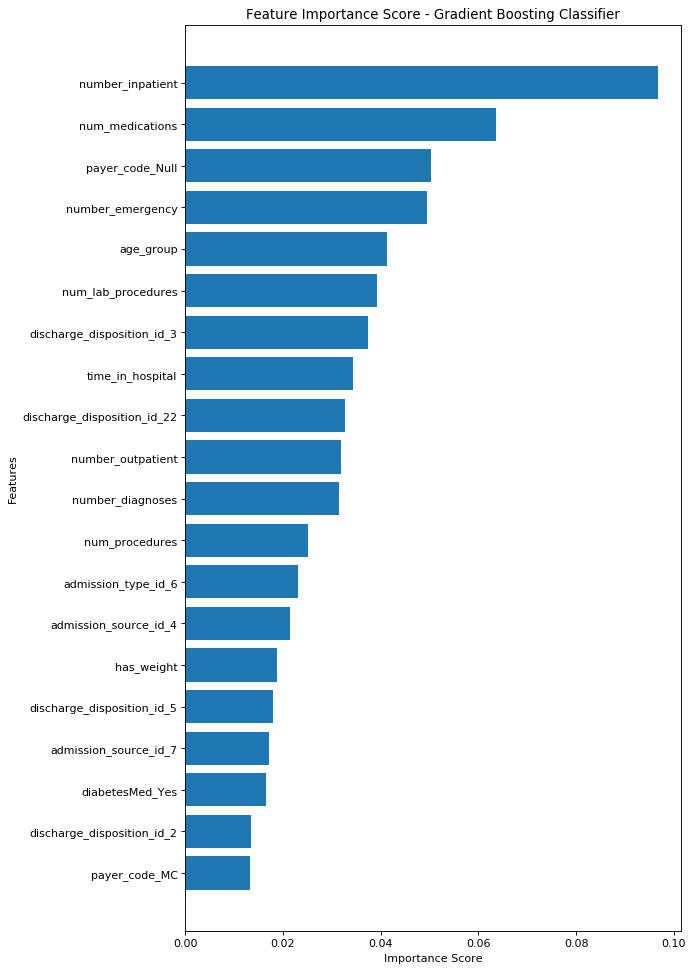

In [58]:
### Plotting 20 more important features ###
import matplotlib.pyplot as plt
num = 20
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = gbc_feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(gbc_feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Gradient Boosting Classifier')
plt.yticks(ylocs, feature_labels)

In [59]:
### Creating a list of 20 most important features ###
important_features= gbc_feature_importances.iloc[:20].index

importance_features=['number_inpatient', 'num_medications', 'payer_code_Null',
       'number_emergency', 'age_group', 'num_lab_procedures',
       'discharge_disposition_id_3', 'time_in_hospital',
       'discharge_disposition_id_22', 'number_outpatient', 'number_diagnoses',
       'num_procedures', 'admission_type_id_6', 'admission_source_id_4',
       'has_weight', 'discharge_disposition_id_5', 'admission_source_id_7',
       'diabetesMed_Yes', 'discharge_disposition_id_2', 'payer_code_MC']

In [61]:
### Creating traning and testing dataset using 20 extracted important features ###
X_train_20F= X_train[importance_features]
X_test_20F=X_test[importance_features]

In [63]:
### Training Sequential Neural Nets for classification using 20 most important features ###
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier_20F = Sequential()
# Adding the input layer and the first hidden layer
classifier_20F.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 20))
# Adding the second hidden layer
classifier_20F.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier_20F.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN
classifier_20F.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier_20F.fit(X_train_20F, y_train, batch_size = 32, epochs = 100)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/100
79474/79474 [==============================] - 2s 22us/step - loss: 0.9205 - accuracy: 0.5593
Epoch 2/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.9023 - accuracy: 0.5707
Epoch 3/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8991 - accuracy: 0.5726
Epoch 4/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8975 - accuracy: 0.5732
Epoch 5/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8959 - accuracy: 0.5751
Epoch 6/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8951 - accuracy: 0.5753
Epoch 7/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8948 - accuracy: 0.5743
Epoch 8/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8941 - accuracy: 0.5747
Epoch 9/100
79474/79474 [==============================] - 2s 21us/step - loss: 

79474/79474 [==============================] - 2s 22us/step - loss: 0.8870 - accuracy: 0.5803
Epoch 75/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8872 - accuracy: 0.5782
Epoch 76/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8873 - accuracy: 0.5789
Epoch 77/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8868 - accuracy: 0.5792
Epoch 78/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8872 - accuracy: 0.5785
Epoch 79/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8869 - accuracy: 0.5796
Epoch 80/100
79474/79474 [==============================] - 2s 22us/step - loss: 0.8869 - accuracy: 0.5794
Epoch 81/100
79474/79474 [==============================] - 2s 21us/step - loss: 0.8871 - accuracy: 0.5798
Epoch 82/100
79474/79474 [==============================] - 2s 22us/step - loss: 0.8867 - accuracy: 0.5791
Epoch 83/100
79474/79474 [========================

In [64]:
### Training Sequential Neural Nets for classification using all the features ###
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier_full = Sequential()
# Adding the input layer and the first hidden layer
classifier_full.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 142))
# Adding the second hidden layer
classifier_full.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier_full.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN
classifier_full.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier_full.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
79474/79474 [==============================] - 2s 25us/step - loss: 0.9206 - accuracy: 0.5542
Epoch 2/100
79474/79474 [==============================] - 2s 27us/step - loss: 0.8966 - accuracy: 0.5742
Epoch 3/100
79474/79474 [==============================] - 2s 25us/step - loss: 0.8937 - accuracy: 0.5765
Epoch 4/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8916 - accuracy: 0.5777
Epoch 5/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8903 - accuracy: 0.5771
Epoch 6/100
79474/79474 [==============================] - 2s 25us/step - loss: 0.8894 - accuracy: 0.5771
Epoch 7/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8885 - accuracy: 0.5784
Epoch 8/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8880 - accuracy: 0.5795
Epoch 9/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8876 - accuracy: 0.5801
Epoch 10/100
79474/79474 [====================

79474/79474 [==============================] - 2s 24us/step - loss: 0.8753 - accuracy: 0.5861
Epoch 78/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8752 - accuracy: 0.5880
Epoch 79/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8751 - accuracy: 0.5869
Epoch 80/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8747 - accuracy: 0.5885
Epoch 81/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8752 - accuracy: 0.5871
Epoch 82/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8746 - accuracy: 0.5879
Epoch 83/100
79474/79474 [==============================] - 2s 23us/step - loss: 0.8747 - accuracy: 0.5870
Epoch 84/100
79474/79474 [==============================] - 2s 25us/step - loss: 0.8746 - accuracy: 0.5862
Epoch 85/100
79474/79474 [==============================] - 2s 24us/step - loss: 0.8749 - accuracy: 0.5862
Epoch 86/100
79474/79474 [========================

In [65]:
### Prediting testing dataset ###
NN_20F=classifier_20F.predict(X_test_20F)
NN__Full=classifier_full.predict(X_test)

In [91]:
### Binarizing the target features ###
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_test, classes=[0, 1, 2])

In [68]:
### Reporting ROC_AUC scores for both NN models ###
import sklearn
from sklearn.metrics import roc_auc_score
print('roc_auc score - NN with 20 Features:', sklearn.metrics.roc_auc_score(y_test, NN_20F))
print('roc_auc score - NN with Full Features:', sklearn.metrics.roc_auc_score(y_test, NN__Full))

roc_auc score - NN with 20 Features: 0.6572828192778647
roc_auc score - NN with Full Features: 0.6615849010405467


In [69]:
### Gradient boosting ###
from sklearn.ensemble import GradientBoostingClassifier
gbc_20F =GradientBoostingClassifier(n_estimators=200, learning_rate=0.10, max_depth=2, random_state=0)
gbc_20F.fit(X_train_20F, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [70]:
###Gradient boosting###
from sklearn.ensemble import GradientBoostingClassifier
gbc_Full =GradientBoostingClassifier(n_estimators=200, learning_rate=0.10, max_depth=2, random_state=0)
gbc_Full.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [107]:
### Prediting testing dataset ###
gbc_20F_prediction = gbc_20F.predict(X_test_20F)
gbc_Full_prediction = gbc_Full.predict(X_test)

In [108]:
### Binarizing the predicted target features with gbc ###
gbc_20F_prediction = label_binarize(gbc_20F_prediction, classes=[0, 1, 2])
gbc_Full_prediction = label_binarize(gbc_Full_prediction, classes=[0, 1, 2])

In [109]:
### Reporting ROC_AUC scores for both gbc models ###
print('roc_auc score - gbc with 20 Features:', sklearn.metrics.roc_auc_score(y_test, gbc_20F_prediction))
print('roc_auc score - gbc with Full Features:', sklearn.metrics.roc_auc_score(y_test, gbc_Full_prediction))

roc_auc score - gbc with 20 Features: 0.5629875875964024
roc_auc score - gbc with Full Features: 0.5660162273912958


In [95]:
###Stochastic gradient descent###
from sklearn.linear_model import SGDClassifier
sgdc_20F=SGDClassifier(loss = 'log',alpha = 0.01, max_iter= 200, penalty= 'l1', random_state = 0)
sgdc_20F.fit(X_train_20F, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=200, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [111]:
### Stochastic gradient descent ###
from sklearn.linear_model import SGDClassifier
sgdc_Full=SGDClassifier(loss = 'log',alpha = 0.01, max_iter= 200, penalty= 'l1', random_state = 0)
sgdc_Full.fit(X_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=200, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [112]:
### Prediting testing dataset ###
sgdc_20F_prediction = sgdc_20F.predict(X_test_20F)
sgdc_prediction_full = sgdc_Full.predict(X_test)

In [113]:
### Binarizing the predicted target features with gbc ###
sgdc_20F_prediction = label_binarize(sgdc_20F_prediction, classes=[0, 1, 2])
sgdc_prediction_full = label_binarize(sgdc_prediction_full, classes=[0, 1, 2])

In [120]:
### Reporting ROC_AUC scores for both sgdc models ###
print('roc_auc score - sgdc with 20 Features:', sklearn.metrics.roc_auc_score(y_test, sgdc_20F_prediction))
print('roc_auc score - sgdc with Full Features:', sklearn.metrics.roc_auc_score(y_test, sgdc_prediction_full))

roc_auc score - sgdc with 20 Features: 0.5363189370728991
roc_auc score - sgdc with Full Features: 0.5363718791400263


In [115]:
###RandomForestClassifier###
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_20F = RandomForestClassifier(n_estimators= 500, bootstrap = True, min_samples_split= 6, max_depth= 8, max_features ='auto' )
# Fit on training data
rf_20F.fit(X_train_20F, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
###RandomForestClassifier###
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_Full = RandomForestClassifier(n_estimators= 500, bootstrap = True, min_samples_split= 6, max_depth= 8, max_features ='auto' )
# Fit on training data
rf_Full.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
### Prediting testing dataset ###
rf_prediction_20F = rf_20F.predict(X_test_20F)
rf_prediction_Full = rf_Full.predict(X_test)

In [122]:
### Binarizing the predicted target features with gbc ###
rf_prediction_20F = label_binarize(rf_prediction_20F, classes=[0, 1, 2])
rf_prediction_Full = label_binarize(rf_prediction_Full, classes=[0, 1, 2])

In [123]:
### Reporting ROC_AUC scores for both sgdc models ###
print('roc_auc score - RandomForest with 20 Features:', sklearn.metrics.roc_auc_score(y_test, rf_prediction_20F))
print('roc_auc score - RandomForest with Full Features:', sklearn.metrics.roc_auc_score(y_test, rf_prediction_Full))

roc_auc score - RandomForest with 20 Features: 0.5570796803640298
roc_auc score - RandomForest with Full Features: 0.5360562950719638
